# Анализ показателей приложения Procrastinate Pro+

## Описание данных

Структура *visits_info_short.csv* (лог сервера с информацией о посещениях сайта):

- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

Структура *orders_info_short.csv* (информация о заказах):

- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.
    
Структура *costs_info_short.csv* (информация о расходах на рекламу):

- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

## 1. Предобработка данных

In [1]:
# подключаем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

#подключаем библиотеки для построения графикво
import matplotlib.pyplot as plt
import seaborn as sns

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

### Visits

In [2]:
try:
    visits = pd.read_csv('C:/Users/arvore/Downloads/Яндекс/Анализ бизнес-показателей/visits_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')

visits.info()    
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


**Изменим типы данных и проверим на дубликаты**

In [3]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])

visits.columns = [name.lower().replace(' ', '_') for name in visits.columns]
visits.columns = visits.columns.str.lower()

In [4]:
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.strftime('%B')

In [5]:
print('Регионы:', visits['region'].unique())
print()
print('Устройства:', visits['device'].unique())
print()
print('Каналы привлечения:', visits['channel'].unique())
print()
print('Количество явных дубликатов:', visits.duplicated().sum())

Регионы: ['United States' 'UK' 'France' 'Germany']

Устройства: ['iPhone' 'Mac' 'Android' 'PC']

Каналы привлечения: ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']

Количество явных дубликатов: 0


**Период исследования сессии**

In [6]:
print('Минимальная дата сессии:', visits['session_start'].dt.date.min())
print('Максимальная дата сессии:', visits['session_start'].dt.date.max())

Минимальная дата сессии: 2019-05-01
Максимальная дата сессии: 2019-10-31


**Kоличество сессий, количество пользователей и их соотношение**

In [7]:
sessions_per_user = visits.groupby(['session_year', 'session_month']).agg(
    {'user_id': ['count', 'nunique']}
)

sessions_per_user.columns = ['sessions', 'users']

sessions_per_user['sessions_per_user'] = (
    sessions_per_user['sessions'] / sessions_per_user['users']
)

sessions_per_user.reset_index()

,session_year,session_month,sessions,users,sessions_per_user
0,2019,August,55996,31064,1.802601
1,2019,July,47970,26672,1.798515
2,2019,June,44623,26042,1.713501
3,2019,May,45765,27111,1.688060
4,2019,October,58919,31175,1.889944
5,2019,September,56628,31871,1.776788


**Считаем среднюю продолжительность сессии (ASL)**

Среднее значение, секунды: 1800.09
Медианное значение, секунды: 1244.00


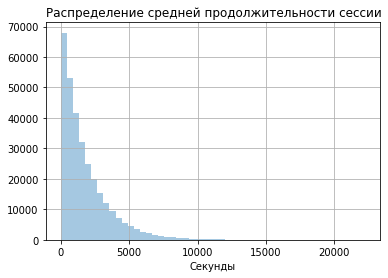

In [8]:
visits['session_duration_sec'] = (
    visits['session_end'] - visits['session_start']
).dt.seconds

print('Среднее значение, секунды: %.2f' %(visits.session_duration_sec.mean()))
print('Медианное значение, секунды: %.2f' %(visits.session_duration_sec.median()))

visits['session_duration_sec'].hist(bins=50, alpha=0.4)
plt.title('Распределение средней продолжительности сессии', loc='left')
plt.xlabel('Секунды')
plt.show()

1. Период исследования сессий пользователей - **с 1 мая 2019 по 31 октября 2019**.
2. Страны, использующие приложение - США, Великобритания, Франция, Германия.
3. Устройстви, с помощью которых осуществляется использование приложения - iPhone, Mac, Android, PC.
4. Каналы привлечения - organic, TipTop, RocketSuperAds, YRabbit, FaceBoom, MediaTornado, AdNonSense, LeapBob, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds.
5. Соотношение количества сессий к количеству пользователей увеличивается, но все еще значение невелико и не превышает двух.
6. В среднем продолжительность сессии составляет около 21 минуты (1244 сек) без учета аномально длинных сессий.

### Orders

In [9]:
try:
    orders = pd.read_csv('C:/Users/arvore/Downloads/Яндекс/Анализ бизнес-показателей/orders_info_short.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')

orders.info()    
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


**Изменим типы данных и проверим на дубликаты**

In [10]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

orders.columns = [name.lower().replace(' ', '_') for name in orders.columns]
orders.columns = orders.columns.str.lower()

print('Количество дубликатов:', orders.duplicated().sum())
print() 
print('Стоимость заказа:', orders['revenue'].unique())

Количество дубликатов: 0

Стоимость заказа: [ 4.99  5.99  9.99 49.99 19.99]


In [11]:
orders.groupby('revenue').agg({'event_dt':'count'}).reset_index()

,revenue,event_dt
0,4.99,38631
1,5.99,780
2,9.99,385
3,19.99,204
4,49.99,212


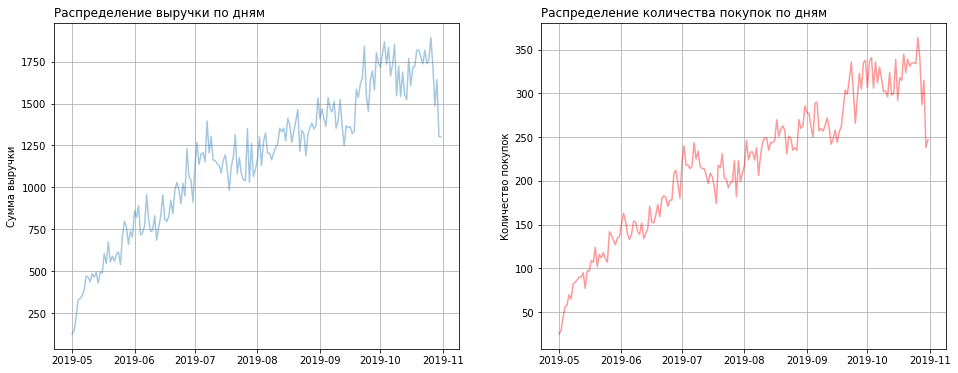

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(
    orders.pivot_table(
        index=orders.event_dt.astype('datetime64[D]'),
        values='revenue',
        aggfunc='sum'
    ), alpha=0.4
)
ax1.grid(True)
ax1.set_title('Распределение выручки по дням',  loc='left')
ax1.set_ylabel('Сумма выручки')

ax2.plot(
    orders.pivot_table(
        index=orders.event_dt.astype('datetime64[D]'),
        values='revenue',
        aggfunc='count'),
    color='r', 
    alpha=0.4
)

ax2.grid(True)
ax2.set_title('Распределение количества покупок по дням',  loc='left')
ax2.set_ylabel('Количество покупок')
plt.show()

1. Для наибольшей доли покупок стоимость заказа составляет 4.99.
2. В течение всего времени идет рост количества покупок и выручки за исключением последних дней.

### Costs

In [13]:
try:
    costs = pd.read_csv('C:/Users/arvore/Downloads/Яндекс/Анализ бизнес-показателей/costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

costs.info()    
costs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


**Изменим типы данных и проверим на дубликаты**

In [14]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

costs.columns = costs.columns.str.lower()

In [15]:
print('Рекламные источники:', costs['channel'].unique())
print()
print('Количество дубликатов:', costs.duplicated().sum())

Рекламные источники: ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']

Количество дубликатов: 0


In [16]:
costs.pivot_table(index='channel',values='costs',aggfunc='sum').sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


1. Компания использует разные каналы для привлечения клиентов. 
2. Наибольшее количество средств вложено в два канала - TipTop и FaceBoom.

### Выводы
1. Дубликатов не обнаружено.
2. Период исследования - **с 1 мая 2019 по 31 октября 2019**.
3. Страны, использующие приложение - США, Великобритания, Франция, Германия.
4. Устройстви, с помощью которых осуществляется использование приложения - iPhone, Mac, Android, PC.
5. Каналы привлечения клиентов - organic, TipTop, RocketSuperAds, YRabbit, FaceBoom, MediaTornado, AdNonSense, LeapBob, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds.
6. Соотношение количества сессий к количеству пользователей увеличивается, но не превышает двух.
7. В среднем продолжительность сессии составляет около **21 минуты (1244 сек)** без учета аномально длинных сессий.
8. Для наибольшей доли покупок стоимость заказа составляет **4.99**.
9. В течение всего времени идет рост количества покупок и выручки за исключением последних дней.
10. Наибольшее количество средств вложено в два канала - **TipTop** и **FaceBoom**.

## 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии

### 2.1. Метрики

In [17]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # определяем дату первого посещения и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
     # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [18]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    dimensions = ['payer'] + dimensions
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) 
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                     
        result = result[['cohort_size'] + list(range(horizon_days))]                                             
        result['cohort_size'] = cohort_sizes                                                                     
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
  
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### 2.2. Построение графиков

In [21]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [22]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [23]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3. Исследовательский анализ данных

#### Составим профили пользователей.

In [25]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(10))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [26]:
min_analysis_date = profiles['dt'].min()

max_analysis_date =  profiles['dt'].max()

print(f'Минимальная дата привлечения пользователей: {min_analysis_date}')
print(f'Максимальная дата привлечения пользователей: {max_analysis_date}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


#### Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [27]:
region =  (profiles
           .pivot_table(
                        index='region',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
           
          )
region['payer_share, %'] = (region.payer / (region.not_payer + region.payer) * 100).round(2)
region

payer,not_payer,payer,"payer_share, %"
region,,,
United States,93100,6902,6.90
UK,16875,700,3.98
France,16787,663,3.80
Germany,14365,616,4.11


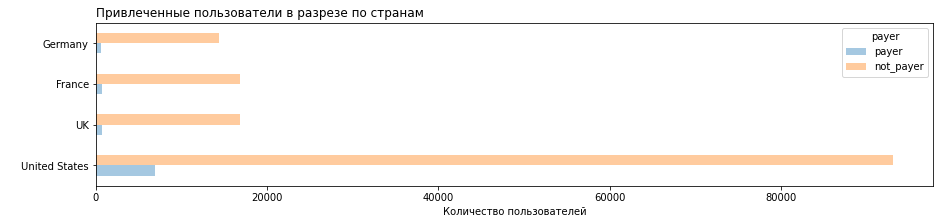

In [28]:
fig, ax = plt.subplots(figsize=(15, 3))
region[['payer', 'not_payer']].plot(kind='barh', stacked=False, ax=ax, alpha=0.4)

ax.set_xlabel('Количество пользователей')
ax.set_ylabel(' ')
ax.set_title('Привлеченные пользователи в разрезе по странам',loc='left')
plt.show()

1. Наибольший поток новых пользовтелей идет из США, как платящих, так и неплатящих.
2. Наибольшая доля платящих по отношенияю к общему количеству также в США, составляет 6,9% от общего числа новых пользователей страны.

#### Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [29]:
device =  (profiles
           .pivot_table(
                        index='device',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
          )
device['payer_share, %'] = (device.payer / (device.not_payer + device.payer) * 100).round(2)
device.sort_values(by='payer_share, %', ascending=False)

payer,not_payer,payer,"payer_share, %"
device,,,
Mac,28130,1912,6.36
iPhone,51097,3382,6.21
Android,32982,2050,5.85
PC,28918,1537,5.05


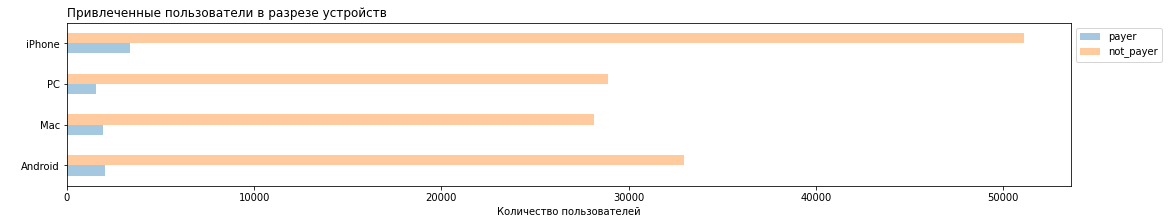

In [30]:
fig, ax = plt.subplots(figsize=(18, 3))
device[['payer', 'not_payer']].plot(kind='barh', stacked=False, ax=ax, alpha=0.4)

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Количество пользователей')
ax.set_ylabel(' ')
ax.set_title('Привлеченные пользователи в разрезе устройств',loc='left')
plt.show()

1. Наиболее эффективна реклама для пользователей телефонов.
2. Наибольший поток новых пользовтелей идет с Айфона, как платящих, так и неплатящих.
3. Наибольшая доля платящих по отношенияю к общему количеству у пользователей Мас.

#### Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [31]:
channel =  (profiles
           .pivot_table(
                        index='channel',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           )
channel['payer_share, %'] = (channel.payer / (channel.not_payer + channel.payer) * 100).round(2)
channel.sort_values(by='payer_share, %', ascending=False)

payer,not_payer,payer,"payer_share, %"
channel,,,
FaceBoom,25587,3557,12.20
AdNonSense,3440,440,11.34
lambdaMediaAds,1924,225,10.47
TipTop,17683,1878,9.60
RocketSuperAds,4096,352,7.91
WahooNetBanner,8100,453,5.30
YRabbit,4147,165,3.83
MediaTornado,4208,156,3.57
LeapBob,8291,262,3.06


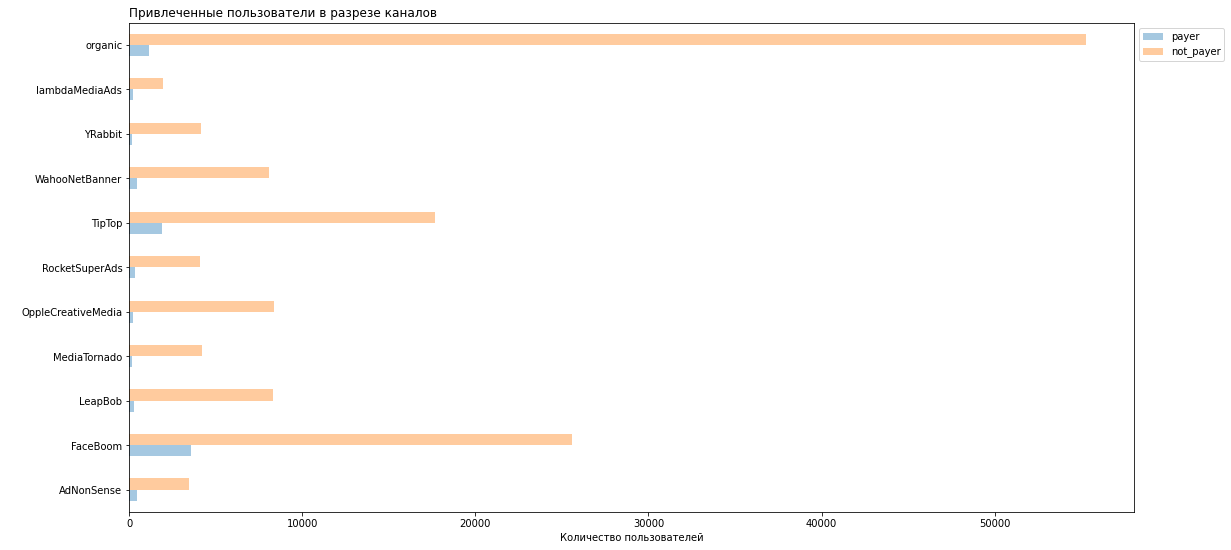

In [32]:
fig, ax = plt.subplots(figsize=(18, 9))
channel[['payer', 'not_payer']].plot(kind='barh', stacked=False, ax=ax, alpha=0.4)

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Количество пользователей')
ax.set_ylabel(' ')
ax.set_title('Привлеченные пользователи в разрезе каналов',loc='left')
plt.show()

1. Наибольшее количество неплатящих пользователей приходят органически.
2. TipTop и FaceBoom являются лидерами привлечения платящих пользователей. 
3. Три наиболее результативных канала - FaceBoom, AdNonSense и lambdaMediaAds, так как их доля выше остальных и превышает 10%. Поэтому стоит рассмотреть AdNonSense и lambdaMediaAds для привлечения новых платящих пользователей.

<b>Выводы:  </b>
1. Период привлечения клиентов - **с 1 мая 2019 по 27 октября 2019**.
2. Наибольший поток новых пользовтелей идет из США. Также доля платящих пользователей этой страны выше остальных.
3. Наиболее эффективна реклама для пользователей телефонов.
4. Наибольшее количество неплатящих пользователей приходят органически.
5. Лидеры привлечения платящих пользователей - **TipTop** и **FaceBoom**.
6. Три наиболее результативных канала - **FaceBoom, AdNonSense** и **lambdaMediaAds**.

## 4. Маркетинг

#### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [33]:
costs_sort = costs.pivot_table(index='channel',values='costs',aggfunc='sum').sort_values(by='costs', ascending=False)
costs_sum = costs.costs.sum().round()
costs_sort['share, %'] = round(costs_sort.costs/costs.costs.sum()*100)

print(f'Общая сумма затрат на рекламу: {costs_sum}')
display(costs_sort)

Общая сумма затрат на рекламу: 105497.0


,costs,"share, %"
channel,,
TipTop,54751.30,52.0
FaceBoom,32445.60,31.0
WahooNetBanner,5151.00,5.0
AdNonSense,3911.25,4.0
OppleCreativeMedia,2151.25,2.0
RocketSuperAds,1833.00,2.0
LeapBob,1797.60,2.0
lambdaMediaAds,1557.60,1.0
MediaTornado,954.48,1.0


1. Компания использует разные каналы привлечения.
2. Более 80% бюджета делят всего две компании - TipTop (52%) и FaceBoom (31%).

#### Построим визуализацию динамики изменения расходов во времени по каждому источнику. 

In [34]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

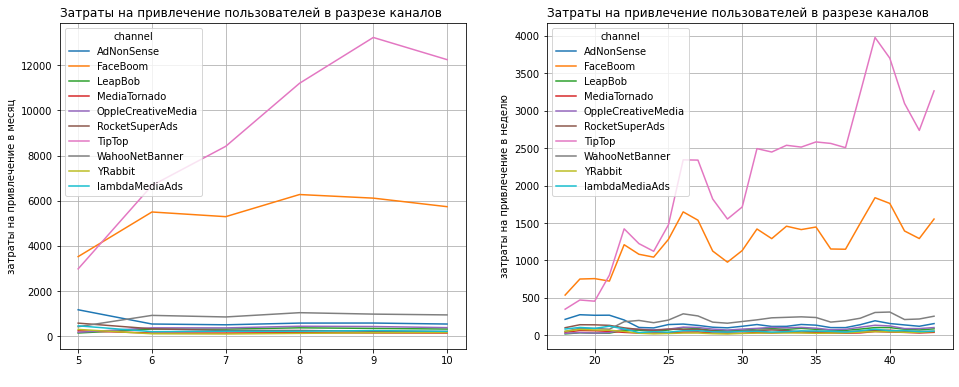

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

(costs
 .pivot_table(
    index=costs.month,
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax1, stacked=False, grid=True)
)

ax1.set_title('Затраты на привлечение пользователей в разрезе каналов', loc='left')
ax1.set_ylabel('затраты на привлечение в месяц')
ax1.set_xlabel(' ')

(costs
 .pivot_table(
    index=costs.week,
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax2, stacked=False, grid=True)
)

ax2.set_title('Затраты на привлечение пользователей в разрезе каналов', loc='left')
ax2.set_ylabel('затраты на привлечение в неделю')
ax2.set_xlabel(' ')
plt.show()

1. Траты на рекламу с каждым месяцем растут только для двух каналов.
2. После 40 недели наблюдается резкое падение финансирования.

#### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [36]:
cac_person = (profiles
              .query('channel != "organic"')[['user_id', 'acquisition_cost']]
              .drop_duplicates()
              .agg({'acquisition_cost': 'mean'})
             )
cac_person

acquisition_cost    1.127481
dtype: float64

In [37]:
cac_channel = (profiles
       .pivot_table(index = 'channel',
                    values = 'acquisition_cost',
                    aggfunc='mean')
       .sort_values(by='acquisition_cost', ascending=False)
       .rename(columns={'acquisition_cost': 'cac'})
      )
cac_channel

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


1. Средняя цена одного пользователя - 1,13.
2. Самая высокая цена пользователя с канала TipTop, прышает средний показатель более, чем в два раза (2,8).
3. Цена привлечения для всех каналов, за исключением TipTop и FaceBoom, ниже среднего САС.

<b>Выводы:  </b>
1. Компания использует разные каналы привлечения.
2. Более 80% бюджета делят всего две компании - TipTop (52%) и FaceBoom (31%), при этом у этих каналов самая высокая цена пользователя.
3. Траты на рекламу с каждым месяцем растут только для двух каналов.
4. Средняя цена одного пользователя - 1,13.

## 5. Окупаемость рекламы

Исключаем органических пользователей, так как на их привлечение не затрачиваются ресурсы.

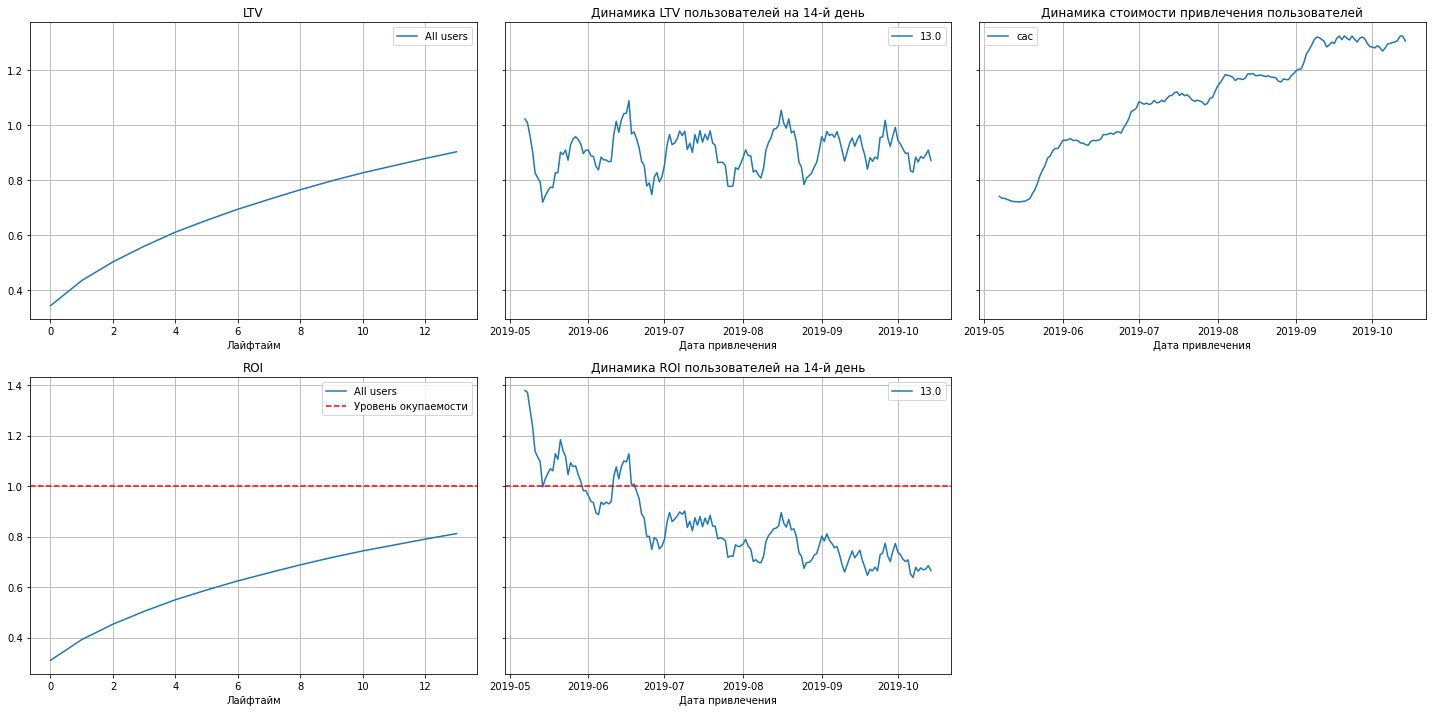

In [38]:
profiles = profiles.query('channel != "organic"')

observation_date = profiles['dt'].max() 
analysis_horizon = 14

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

1. ROI не превышает уровень окупаемости даже на 14 день.
2. САС растет.
3. В середине июня начался спад окупаемости.

### 5.1. Разбивка по каналам

**ROI, САС и LTV**

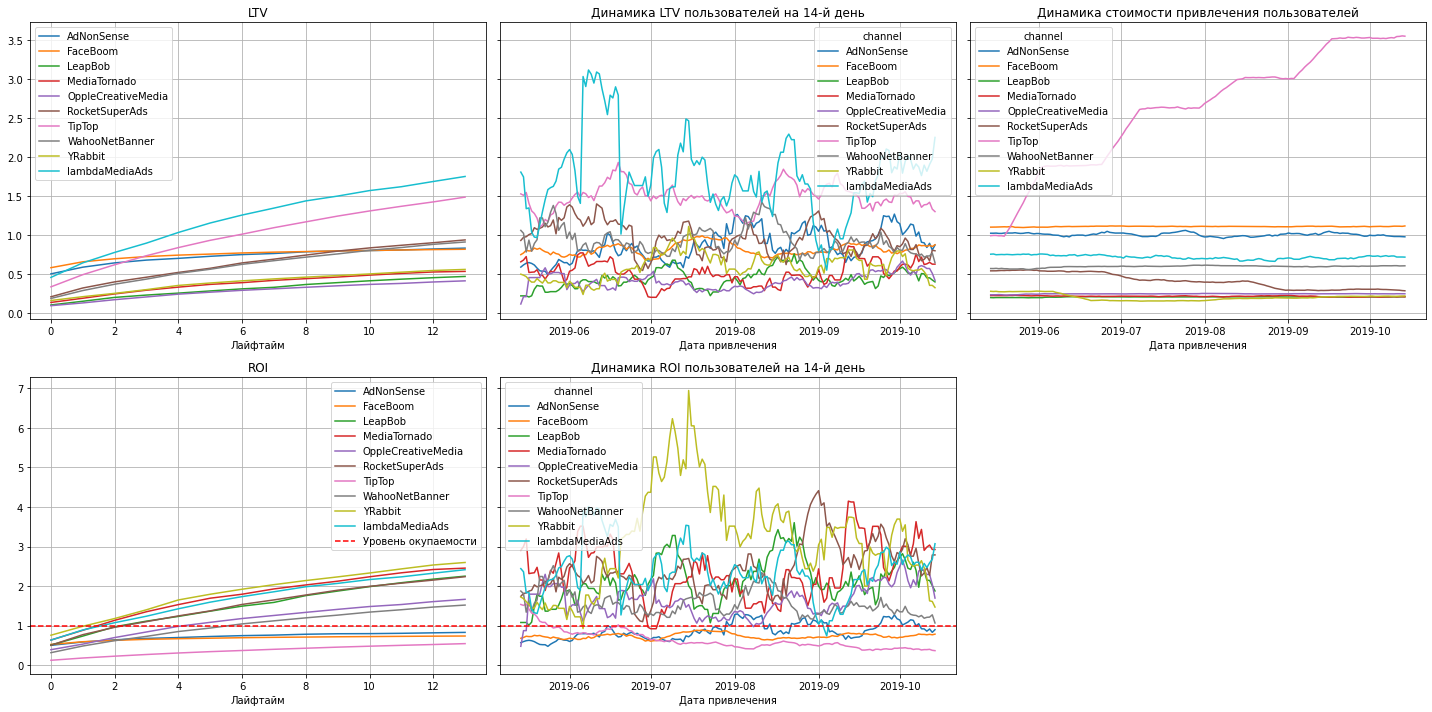

In [39]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
)

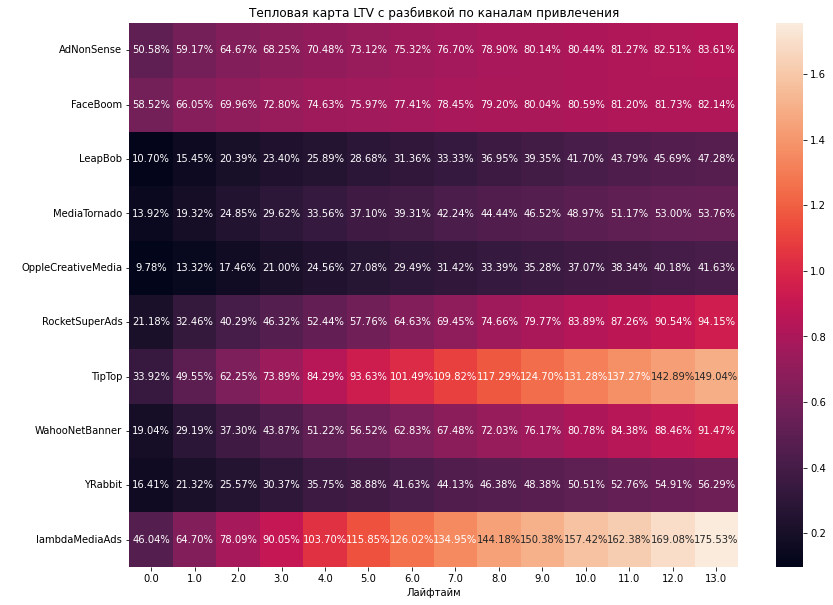

In [40]:
plt.figure(figsize=(30, 10))

sns.heatmap(
    ltv_grouped.drop(columns = ['cohort_size']), 
    annot=True, 
    fmt='.2%', 
    ax=plt.subplot(1, 2, 2)
            )
plt.title('Тепловая карта LTV с разбивкой по каналам привлечения')
plt.xlabel('Лайфтайм')
plt.ylabel(' ')
plt.show()

1. На двухнедельном лайфтайме затраты на TipTop, FaceBoom и AdNonSense - не окупаются.
2. Затраты на рекламу TipTop увеличиваются каждый месяц.
3. Перспективным каналом кажется lambdaMediaAds - низкая стоимость привлечения (0,72)и высокие показатели пожизненнаой ценности клиента.

**Разбивка по каналам для топ-4 канала по САС**

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802


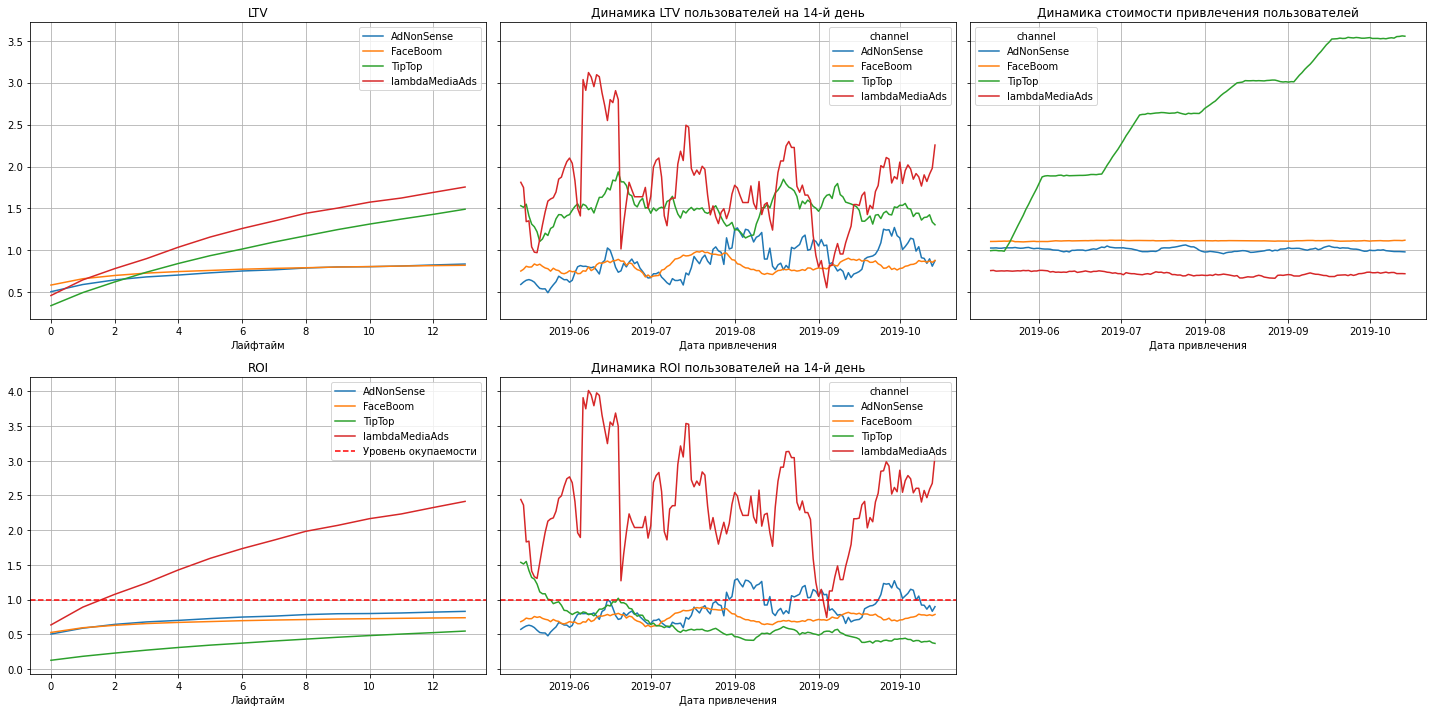

In [41]:
display(cac_channel.head(4))

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel == ["TipTop", "FaceBoom", "lambdaMediaAds",  "AdNonSense"]'), orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
)

1. Наилучшие показатели показывает lambdaMediaAds, хотя на остальные три канала уходит наибольшая доля бюджета.
2. Топ-3 по САС не окупается в течение двух недель.

**Взаимосвязь канала и страны привлечения**

In [42]:
channel_region = (
     profiles
     .pivot_table(index='channel',
                  columns='region',
                  aggfunc={'user_id': 'count'}
                 )
     .sort_values(by=('user_id', 'United States'), 
                  ascending=False)
 ).div(
     profiles
     .pivot_table(columns='region',
                  aggfunc={'user_id': 'count'}
                 )
     .values
 ).fillna(0).style.format('{:.2%}')

channel_region

1. Каналы привлечения работают либо в Америке, либо в Европе. 
2. Для стран Европы количество пользователей между каналами распределено более равномерно, чем для США.

**Конверсия и удержание**

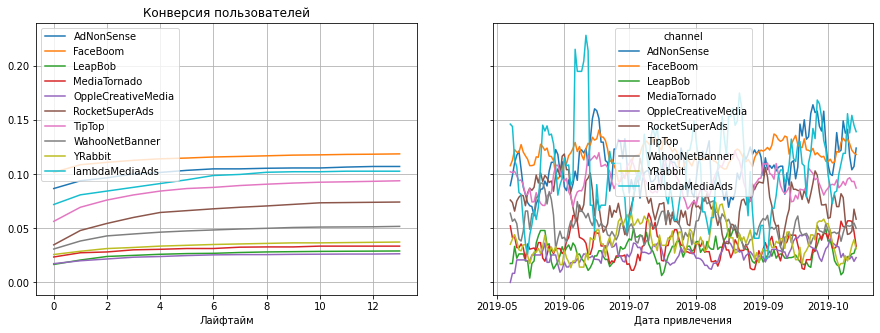

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

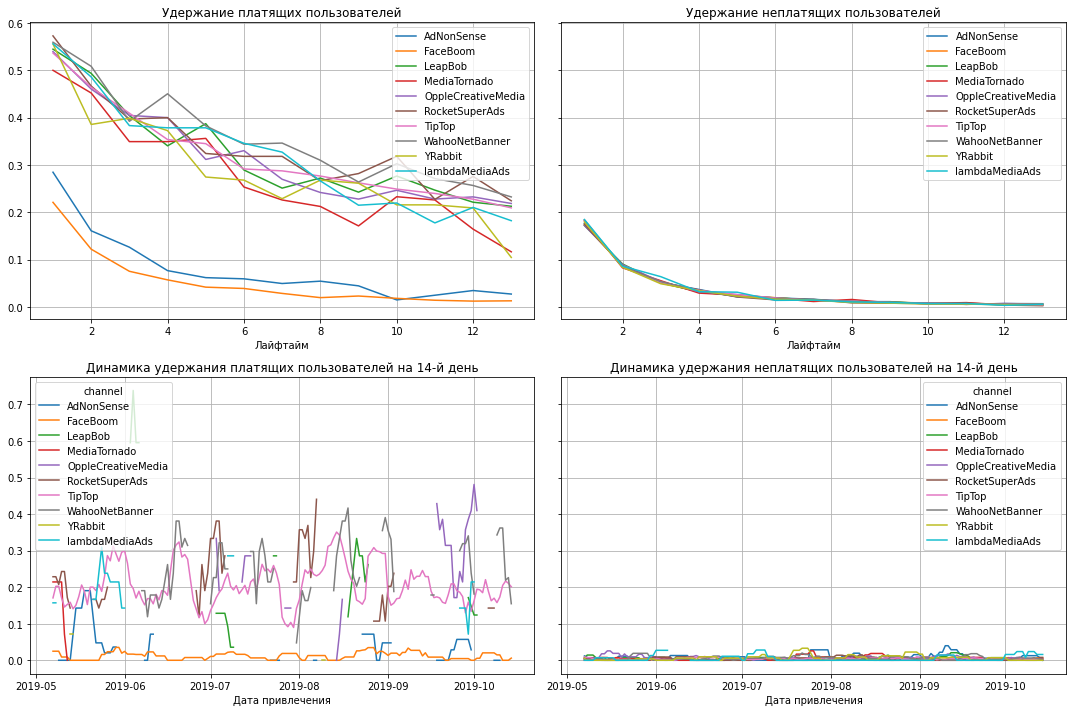

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, analysis_horizon)

1. Выше всего конверсия у пользователей, привлеченных посредством FaceBoom. 
2. Динамика у всех пользователей в течение двухнедельного лайфтайма практически отсутствует.
3. Хуже всего из платящих удерживаются пользователи из FaceBoom и AdNonSense.

### 5.2. Разбивка по странам

**ROI и LTV**

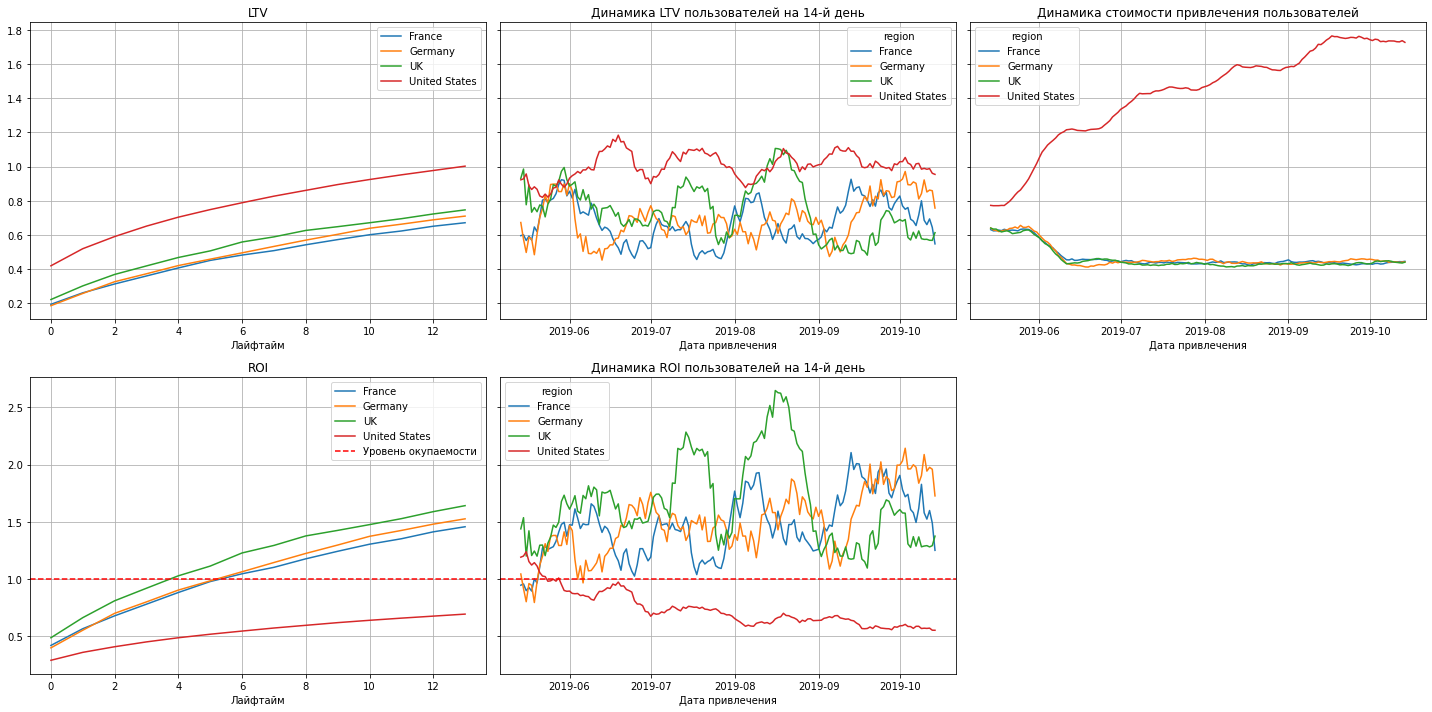

In [45]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
)

1. Затраты на рекламу в Европе остаются неизменными и окупаются.
2. В США стаюильно затраты растут и перестали окупаться с июня.

**Конверсия и удержание**

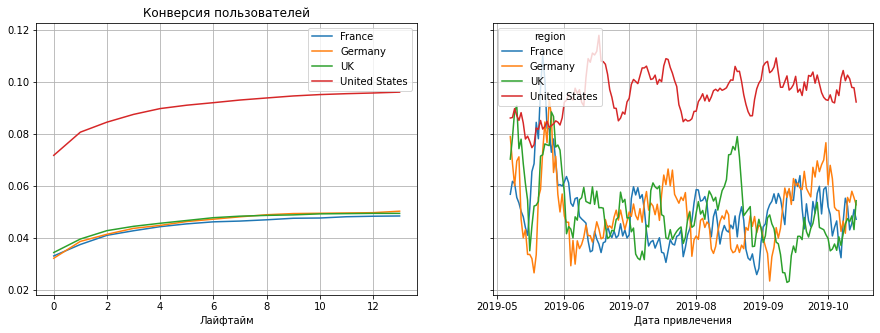

In [46]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

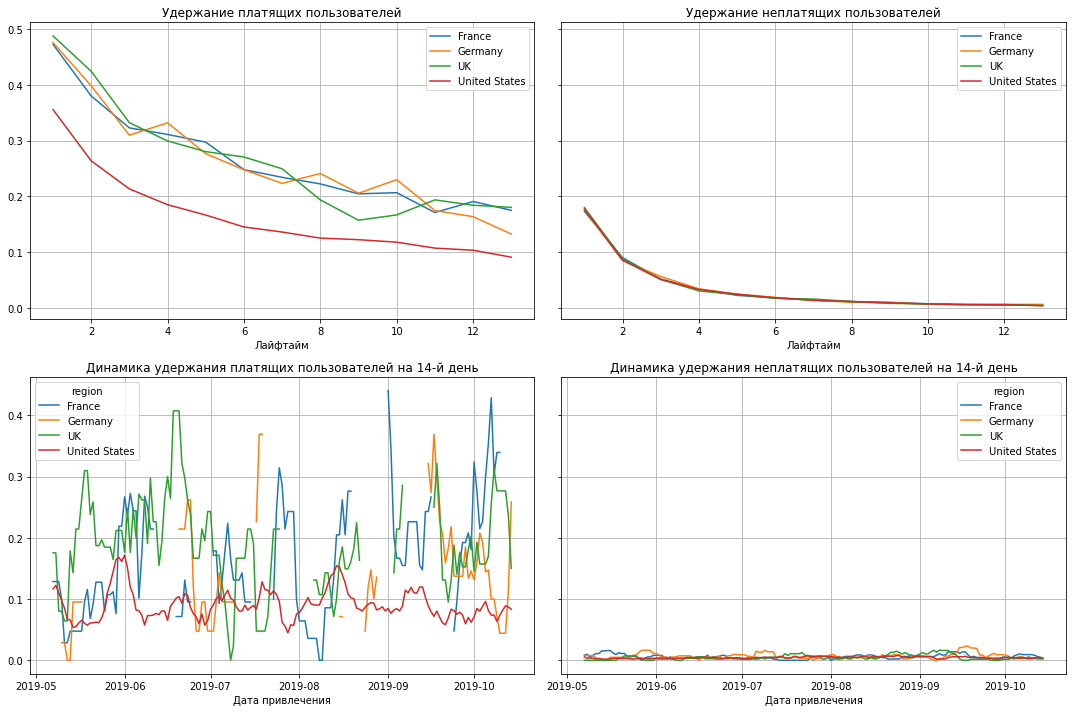

In [47]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, analysis_horizon)

1. Конверсия пользователей США почти в два раза выше конверсии пользователей других стран, но удержание платящих пользователей ниже остальных. 
2. Удержание неплатящих пользователей для всех стран низкое.

### 5.3. Разбивка по устройствам

**ROI и LTV**

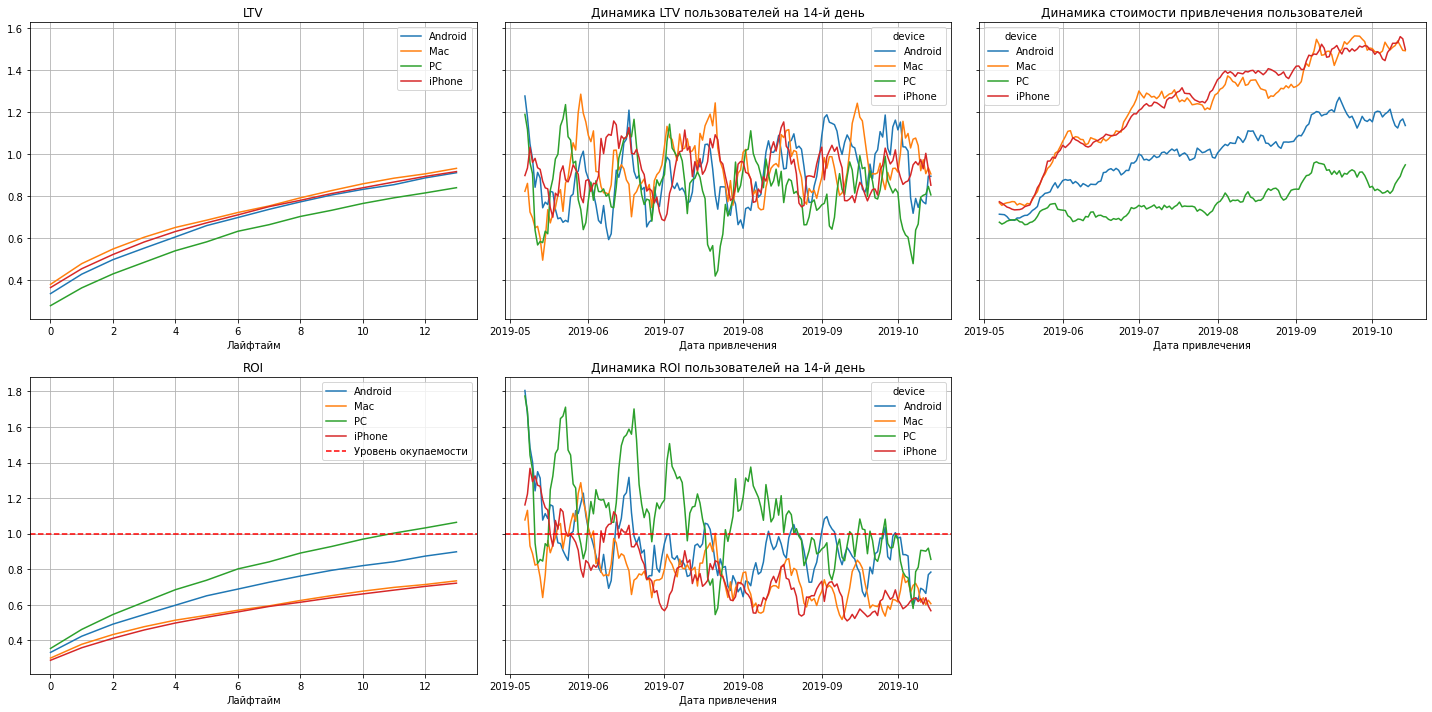

In [48]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

1. Реклама к 11-му дню окупается только для РС, для остальных устрой не окупается в течение 14 дней;
2. САС растет, значит, рекламный бюджет увеличивается для всех устройств, осбенно для Apple;
3. Начиная с середины августа, привлеченные клиенты перестают окупаться в двухнедельном лайфтайме для всех устройств.

**Конверсия и удержание**

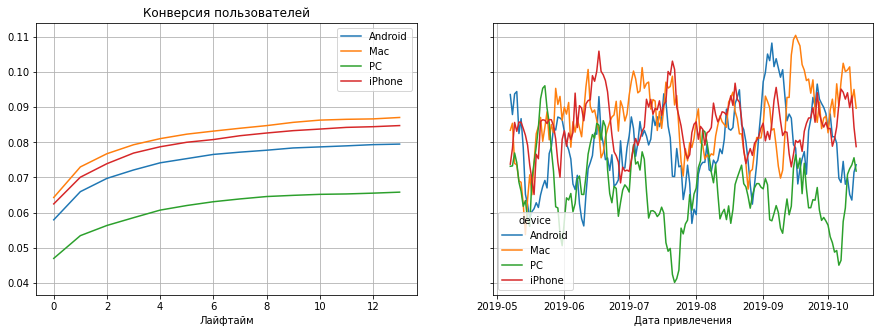

In [49]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

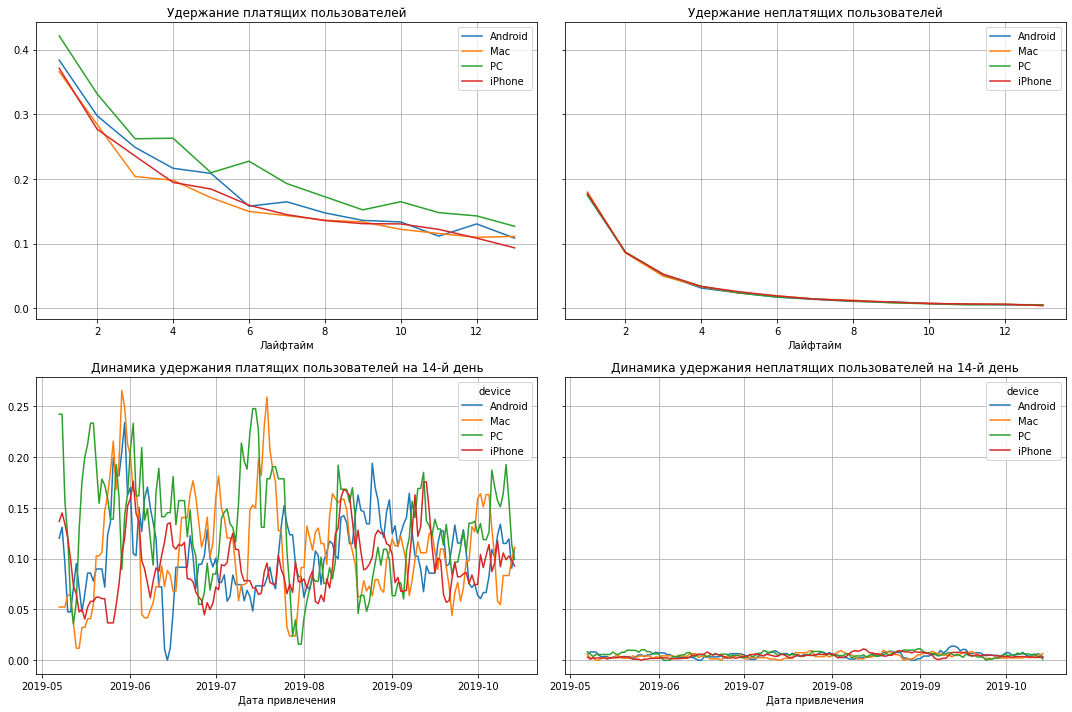

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, analysis_horizon)

1. Пользователи продукции Apple лучше остальных конвертируются в платящих.
2. Пользователи РС наименее хорошо конвертируются, но немного лучше остальных удерживаются.

**Выводы:**
1. На двухнедельном лайфтайме затраты на TipTop, FaceBoom и AdNonSense - не окупаются в течение двух недель.
2. Затраты на рекламу TipTop увеличиваются каждый месяц.
3. Перспективным каналом кажется lambdaMediaAds - низкая стоимость привлечения (0,72) и высокие показатели пожизненнаой ценности клиента.
4. Каналы привлечения работают либо в Америке, либо в Европе.
5. Для стран Европы количество пользователей между каналами распределено более равномерно, чем для США.
6. Выше всего конверсия у пользователей, привлеченных посредством FaceBoom.
7. Хуже всего из платящих удерживаются пользователи из FaceBoom и AdNonSense.
8. Затраты на рекламу в Европе остаются неизменными и окупаются.
9. В США стабильно затраты на рекламу растут и перестали окупаться с июня. Конверсия пользователей США почти в два раза выше конверсии пользователей других стран, но удержание платящих пользователей ниже остальных.
10. Удержание неплатящих пользователей для всех стран низкое.
11. Реклама к 11-му дню окупается только для РС, для остальных устрой не окупается в течение 14 дней;
12. САС растет, значит, рекламный бюджет увеличивается для всех устройств, осбенно для Apple;
13. Начиная с середины августа, привлеченные клиенты перестают окупаться в двухнедельном лайфтайме для всех устройств.
14. Пользователи продукции Apple лучше остальных конвертируются в платящих. В то время как пользователи РС конвертируются хуже остальных, но немного лучше остальных удерживаются.

## 6. Выводы

1. В среднем продолжительность сессии составляет около **21 минуты** (1244 сек).
2. Для наибольшей доли покупок стоимость заказа составляет ***4,99***. В то время как средняя цена одного пользователя - ***1,13***.

3. Страны, использующие приложение - США, Великобритания, Франция, Германия. **Наибольший поток новых пользователей идет из США**.
4. Затраты на рекламу в Европе остаются неизменными и окупаются. В то время как *в США стабильно растут затраты на рекламу и перестали окупаться с июня*. 
5. Конверсия пользователей США почти в два раза выше конверсии пользователей других стран, но удержание платящих пользователей ниже остальных.

5. Устройства, с помощью которых осуществляется использование приложения - iPhone, Mac, Android, PC.
6. Реклама к 11-му дню окупается только для РС, для остальных устройств не окупается в течение 14 дней;
7. Пользователи продукции Apple лучше остальных конвертируются в платящих. В то время как пользователи РС конвертируются хуже остальных, но немного лучше остальных удерживаются.

8. Каналы привлечения клиентов - organic, TipTop, RocketSuperAds, YRabbit, FaceBoom, MediaTornado, AdNonSense, LeapBob, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds.
9. Компания использует разные каналы привлечения. Каналы привлечения работают либо в Америке, либо в Европе.
10. **Более 80% бюджета делят всего две компании** - TipTop (52%) и FaceBoom (31%), при этом у этих каналов самая высокая цена пользователя. Тем не менее они являются лидерами привлечения платящих пользователей.
11. Наибольшее количество неплатящих пользователей приходят органически.
12. **Затраты на TipTop, FaceBoom и AdNonSense - не окупаются в течение двух недель**. Также хуже всего из платящих удерживаются пользователи FaceBoom и AdNonSense.
13. Выше всего конверсия у пользователей, привлеченных посредством FaceBoom.
14. Перспективным каналом кажется **lambdaMediaAds** - низкая стоимость привлечения (0,72) и высокие показатели пожизненнаой ценности клиента.

## 7. Рекомендации

1. С учетом того, что подавляющее количество пользователей из США, необходиом проработать отношения с рекламными площадками этого направления:
    - выявыить проблемы низкого удержания для площадок
    - как вариант, отказаться от FaceBoom и перенаправить рекламные средства в пользу других каналов;
    - выявить причину роста САС канала TipTop и по возможности устранить ее. Если это невозможно, то отказаться от этой рекламной площадки в пользу других;
    - достаточно перспективным выглядит lambdaMediaAds (низкий САС, неплохое привлечение и удержание, конверсия на уровне);
2. Обратить внимание на европейский рынок, например, увеличить расходы на рекламу в lambdaMediaAds и снизить в AdNonSense;
3. Поработать с органическими пользователями: это существенная доля дохода приложения.
4. Сделать акцент на увеличении цены заказа для получения большей прибыли.